### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

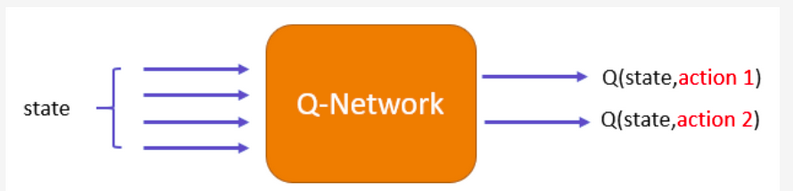

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
R_TRACK = 10
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.max_epsilon = 1
        self.epsilon = self.max_epsilon
        self.decay_rate = 0.001
        self.min_epsilon = 0.01
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        self.avg_reward = deque(maxlen=R_TRACK)
        # create main model and target model
        self.model = self.build_model()

        # Initialize the value of the states tracked for all samples
        self.states_tracked_1 = []
        self.states_tracked_2 = []
        # For Sample state-action pair 1: We are going to track state (2,4,6) and action (2,3) at index 11 in the action space.
        self.track_state_1 = np.array(env.state_encod_arch2((2,4,6))).reshape(1, self.state_size)
        # For Sample state-action pair 2: We are going to track state (1,2,3) and action (1,2) at index 6 in the action space.
        self.track_state_2 = np.array(env.state_encod_arch2((1,2,3))).reshape(1, self.state_size)


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        # model.add(Dense(32, activation='relu',
        #                 kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model



    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        
        # self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)

        z = np.random.random()
        if z <= self.epsilon:
            return random.choice(env.action_space)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) 
            state = np.array(env.state_encod_arch2(state)).reshape(1, self.state_size)

            # Use the model to predict the Q_values.
            action = self.model.predict(state)
            # return action
            # q_vals_possible = [action[0][i] for i in env.action_space]

            return env.action_space[np.argmax(action[0])]
    

    def append_sample(self, state, action, reward, next_state,done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, dones = [], [], []
            
            for i in range(self.batch_size):
                
                # Write your code from here
                state, action, reward, next_state, done = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state)
                dones.append(done)
            
            # 1. Predict the target from earlier model, Optimization preventing calls to multiple predicts
            # target = self.model.predict(update_input, max_queue_size=100, workers=2, use_multiprocessing=True)
            # target_qval = self.model.predict(update_output, max_queue_size=100, workers=2, use_multiprocessing=True)
            target = self.model.predict(np.vstack([update_input,update_output]))
            target_qval = target[0:int(len(target)/2)]
            target = target[int(len(target)/2):int(len(target))]
            # 2. Get the target for the Q-network
            
            
            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
              if dones[i]:
                  target[i][env.action_encod(actions[i])] = rewards[i]
              else: # non-terminal state
                  # print(actions[i])
                  # print(target[i][actions[i]])
                  target[i][env.action_encod(actions[i])] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values        
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
                
        
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        # q_value_1 = self.model.predict(self.track_state_1)
        # q_value_2 = self.model.predict(self.track_state_2)
        q_value_1 = self.model.predict(np.vstack([self.track_state_1,self.track_state_2]))
        q_value_2 = q_value_1[0:int(len(q_value_1)/2)]
        q_value_1 = q_value_1[int(len(q_value_1)/2):int(len(q_value_1))]

        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_1.append(q_value_1[0][11])    ## action (2,3) at index 11 in the action space
        self.states_tracked_2.append(q_value_2[0][6])     ## action (1,2) at index 6 in the action space


    def save(self, name):
        self.model.save_weights(name)

In [5]:
episode_time = 24*30   # 24 hrs for 30 days per episode
Episodes = 5000       # No. of Episodes

m = 5                  # No. Locations
t = 24                 # No. of hrs in a day
d = 7                  # No. of days in a week 
state_size = m+t+d  ## require as len for the encoded  nn input

# Invoke Env class
env = CabDriver()
# state = env.reset()

# Invoke agent class
agent = DQNAgent(action_size=len(env.action_space), state_size = state_size)  ### len(env.state_space)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state
rewards_init_state = []
score_tracked = []


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                693       
Total params: 1,877
Trainable params: 1,877
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### DQN block

In [ ]:
for episode in tqdm(range(Episodes)):

    terminal_state = False
    score = 0
    
    # Reset at the start of each episode
    state = env.reset()
    # State Initialization 
    initial_state = state


    total_time = 0  
    while not terminal_state:    
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state)
        # 2. Evaluate your reward and next state
        next_state, reward, terminal_state = env.step(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        total_time+=1
        
    # Store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
        
    agent.epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate*episode)
    agent.avg_reward.append(score)
    # Every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, initial_state {1}, reward {2}, memory_length {3}, epsilon {4} total_epochs {5} episode_time {6}".format(episode+1, 
                                                                         initial_state,
                                                                         np.mean(agent.avg_reward),
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time, env.episode_time))

    # Total rewards per episode
    score_tracked.append(score)

    # Save the Q_value of the state-action pair we are tracking (every 5 episodes)
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    ## Saving the 'DQN_model' and 'model_weights' every 1000th episode.
    if(episode % 1000 == 0):
        save_obj(score_tracked, "score_tracked")
        print("Saving Model {}".format(episode))
        agent.save(name="DQN_model.h5")                     ## Saves DQN model in Keras H5 format
        save_obj(agent.states_tracked_1,"states_tracked_1")
        save_obj(agent.states_tracked_2,"states_tracked_2")
        # print("Saving Model {} Weights".format(episode))
        # agent.save_weights_numpy(name="model_weights.pkl")

  0%|          | 1/20000 [00:13<74:38:54, 13.44s/it]

Saving Model 0


  0%|          | 10/20000 [02:12<75:42:06, 13.63s/it]

episode 10, initial_state (2, 9, 3), reward -61.1, memory_length 1447, epsilon 0.9911299749851548 total_epochs 126 episode_time 728.0


  0%|          | 20/20000 [04:26<76:06:08, 13.71s/it]

episode 20, initial_state (4, 5, 3), reward -13.5, memory_length 2000, epsilon 0.9813675686203779 total_epochs 128 episode_time 723.0


  0%|          | 30/20000 [06:42<73:19:39, 13.22s/it]

episode 30, initial_state (3, 8, 1), reward 32.5, memory_length 2000, epsilon 0.9717022998219388 total_epochs 104 episode_time 723.0


  0%|          | 40/20000 [09:00<76:47:05, 13.85s/it]

episode 40, initial_state (4, 10, 6), reward 45.6, memory_length 2000, epsilon 0.962133202054903 total_epochs 120 episode_time 728.0


  0%|          | 50/20000 [11:17<75:18:04, 13.59s/it]

episode 50, initial_state (4, 17, 2), reward 4.5, memory_length 2000, epsilon 0.9526593184015199 total_epochs 123 episode_time 728.0


  0%|          | 60/20000 [13:33<76:06:25, 13.74s/it]

episode 60, initial_state (2, 13, 2), reward 12.2, memory_length 2000, epsilon 0.9432797014655288 total_epochs 136 episode_time 722.0


  0%|          | 70/20000 [15:46<75:52:59, 13.71s/it]

episode 70, initial_state (0, 5, 2), reward -4.6, memory_length 2000, epsilon 0.9339934132774199 total_epochs 122 episode_time 729.0


  0%|          | 80/20000 [18:03<73:16:10, 13.24s/it]

episode 80, initial_state (4, 22, 6), reward 125.4, memory_length 2000, epsilon 0.9247995252006359 total_epochs 108 episode_time 727.0


  0%|          | 90/20000 [20:27<78:54:43, 14.27s/it]

episode 90, initial_state (4, 12, 3), reward 99.4, memory_length 2000, epsilon 0.9156971178387074 total_epochs 118 episode_time 723.0


  0%|          | 100/20000 [22:47<79:37:43, 14.41s/it]

episode 100, initial_state (4, 10, 3), reward 6.4, memory_length 2000, epsilon 0.906685280943313 total_epochs 124 episode_time 726.0


  1%|          | 110/20000 [25:10<76:49:41, 13.91s/it]

episode 110, initial_state (4, 10, 6), reward 77.2, memory_length 2000, epsilon 0.8977631133232531 total_epochs 113 episode_time 725.0


  1%|          | 120/20000 [27:27<75:59:25, 13.76s/it]

episode 120, initial_state (0, 21, 0), reward 185.9, memory_length 2000, epsilon 0.8889297227543306 total_epochs 113 episode_time 725.0


  1%|          | 130/20000 [29:46<77:21:02, 14.01s/it]

episode 130, initial_state (2, 17, 2), reward 173.0, memory_length 2000, epsilon 0.8801842258901273 total_epochs 123 episode_time 721.0


  1%|          | 140/20000 [32:03<76:00:40, 13.78s/it]

episode 140, initial_state (1, 1, 5), reward 151.5, memory_length 2000, epsilon 0.871525748173669 total_epochs 125 episode_time 724.0


  1%|          | 150/20000 [34:19<73:59:39, 13.42s/it]

episode 150, initial_state (1, 20, 6), reward 74.4, memory_length 2000, epsilon 0.8629534237499686 total_epochs 115 episode_time 722.0


  1%|          | 160/20000 [36:30<70:38:22, 12.82s/it]

episode 160, initial_state (2, 16, 6), reward -14.3, memory_length 2000, epsilon 0.8544663953794402 total_epochs 105 episode_time 721.0


  1%|          | 170/20000 [38:48<75:08:33, 13.64s/it]

episode 170, initial_state (2, 20, 3), reward 179.8, memory_length 2000, epsilon 0.846063814352174 total_epochs 114 episode_time 726.0


  1%|          | 180/20000 [41:13<78:29:31, 14.26s/it]

episode 180, initial_state (3, 0, 4), reward 224.0, memory_length 2000, epsilon 0.8377448404030652 total_epochs 116 episode_time 723.0


  1%|          | 190/20000 [43:39<77:42:36, 14.12s/it]

episode 190, initial_state (2, 12, 6), reward 178.8, memory_length 2000, epsilon 0.8295086416277863 total_epochs 116 episode_time 722.0


  1%|          | 200/20000 [46:00<78:53:34, 14.34s/it]

episode 200, initial_state (2, 5, 2), reward 131.1, memory_length 2000, epsilon 0.8213543943995963 total_epochs 129 episode_time 724.0


  1%|          | 210/20000 [48:21<77:45:05, 14.14s/it]

episode 210, initial_state (0, 18, 1), reward 207.5, memory_length 2000, epsilon 0.8132812832869774 total_epochs 119 episode_time 730.0


  1%|          | 220/20000 [50:46<79:41:20, 14.50s/it]

episode 220, initial_state (0, 5, 1), reward 277.3, memory_length 2000, epsilon 0.8052885009720903 total_epochs 116 episode_time 721.0


  1%|          | 230/20000 [53:19<84:12:27, 15.33s/it]

episode 230, initial_state (2, 12, 3), reward 311.6, memory_length 2000, epsilon 0.797375248170043 total_epochs 119 episode_time 722.0


  1%|          | 240/20000 [55:50<83:38:26, 15.24s/it]

episode 240, initial_state (4, 15, 3), reward 420.1, memory_length 2000, epsilon 0.789540733548961 total_epochs 130 episode_time 722.0


  1%|▏         | 250/20000 [58:20<82:58:30, 15.12s/it]

episode 250, initial_state (4, 10, 6), reward 294.0, memory_length 2000, epsilon 0.7817841736508534 total_epochs 120 episode_time 722.0


  1%|▏         | 260/20000 [1:00:54<80:22:13, 14.66s/it]

episode 260, initial_state (4, 23, 6), reward 342.7, memory_length 2000, epsilon 0.7741047928132664 total_epochs 113 episode_time 726.0


  1%|▏         | 270/20000 [1:03:31<85:57:31, 15.68s/it]

episode 270, initial_state (2, 8, 1), reward 140.3, memory_length 2000, epsilon 0.766501823091717 total_epochs 124 episode_time 727.0


  1%|▏         | 280/20000 [1:06:29<91:14:00, 16.66s/it]

episode 280, initial_state (0, 19, 2), reward 67.4, memory_length 2000, epsilon 0.7589745041828969 total_epochs 120 episode_time 724.0


  1%|▏         | 290/20000 [1:09:04<87:05:26, 15.91s/it]

episode 290, initial_state (2, 17, 5), reward 157.2, memory_length 2000, epsilon 0.7515220833486427 total_epochs 139 episode_time 728.0


  2%|▏         | 300/20000 [1:11:39<83:24:56, 15.24s/it]

episode 300, initial_state (1, 0, 5), reward 53.6, memory_length 2000, epsilon 0.7441438153406604 total_epochs 130 episode_time 722.0


  2%|▏         | 310/20000 [1:14:07<82:23:05, 15.06s/it]

episode 310, initial_state (3, 14, 1), reward 360.7, memory_length 2000, epsilon 0.7368389623260008 total_epochs 123 episode_time 725.0


  2%|▏         | 320/20000 [1:16:47<90:03:57, 16.48s/it]

episode 320, initial_state (4, 22, 6), reward 379.7, memory_length 2000, epsilon 0.7296067938132749 total_epochs 127 episode_time 723.0


  2%|▏         | 330/20000 [1:19:29<86:42:08, 15.87s/it]

episode 330, initial_state (1, 4, 6), reward 282.3, memory_length 2000, epsilon 0.7224465865796047 total_epochs 117 episode_time 731.0


  2%|▏         | 340/20000 [1:22:00<83:21:28, 15.26s/it]

episode 340, initial_state (2, 4, 4), reward 392.8, memory_length 2000, epsilon 0.7153576245982999 total_epochs 111 episode_time 724.0


  2%|▏         | 350/20000 [1:24:37<88:59:21, 16.30s/it]

episode 350, initial_state (1, 20, 6), reward 469.6, memory_length 2000, epsilon 0.7083391989672547 total_epochs 134 episode_time 724.0


  2%|▏         | 360/20000 [1:27:15<82:12:38, 15.07s/it]

episode 360, initial_state (1, 11, 5), reward 510.6, memory_length 2000, epsilon 0.7013906078380578 total_epochs 112 episode_time 727.0


  2%|▏         | 370/20000 [1:29:51<85:23:48, 15.66s/it]

episode 370, initial_state (4, 8, 4), reward 519.0, memory_length 2000, epsilon 0.6945111563458054 total_epochs 129 episode_time 725.0


  2%|▏         | 380/20000 [1:32:25<84:21:31, 15.48s/it]

episode 380, initial_state (0, 7, 3), reward 579.3, memory_length 2000, epsilon 0.6877001565396155 total_epochs 122 episode_time 724.0


  2%|▏         | 390/20000 [1:35:04<86:25:16, 15.87s/it]

episode 390, initial_state (1, 5, 1), reward 510.7, memory_length 2000, epsilon 0.6809569273138314 total_epochs 125 episode_time 723.0


  2%|▏         | 400/20000 [1:37:37<81:48:08, 15.02s/it]

episode 400, initial_state (3, 3, 6), reward 464.1, memory_length 2000, epsilon 0.6742807943399114 total_epochs 111 episode_time 724.0


  2%|▏         | 410/20000 [1:40:13<84:46:14, 15.58s/it]

episode 410, initial_state (0, 5, 3), reward 438.6, memory_length 2000, epsilon 0.6676710899989946 total_epochs 130 episode_time 722.0


  2%|▏         | 420/20000 [1:42:46<84:06:20, 15.46s/it]

episode 420, initial_state (3, 12, 1), reward 512.1, memory_length 2000, epsilon 0.6611271533151388 total_epochs 130 episode_time 728.0


  2%|▏         | 430/20000 [1:45:26<87:59:22, 16.19s/it]

episode 430, initial_state (0, 16, 6), reward 554.1, memory_length 2000, epsilon 0.6546483298892222 total_epochs 131 episode_time 721.0


  2%|▏         | 440/20000 [1:48:05<88:41:38, 16.32s/it]

episode 440, initial_state (2, 21, 3), reward 675.5, memory_length 2000, epsilon 0.6482339718335033 total_epochs 129 episode_time 726.0


  2%|▏         | 450/20000 [1:50:43<83:34:33, 15.39s/it]

episode 450, initial_state (1, 14, 0), reward 584.2, memory_length 2000, epsilon 0.6418834377068311 total_epochs 129 episode_time 724.0


  2%|▏         | 460/20000 [1:53:22<86:10:12, 15.88s/it]

episode 460, initial_state (3, 3, 2), reward 693.7, memory_length 2000, epsilon 0.635596092450501 total_epochs 122 episode_time 726.0


  2%|▏         | 470/20000 [1:55:50<80:44:36, 14.88s/it]

episode 470, initial_state (1, 21, 3), reward 734.0, memory_length 2000, epsilon 0.6293713073247477 total_epochs 119 episode_time 722.0


  2%|▏         | 480/20000 [1:58:28<84:39:41, 15.61s/it]

episode 480, initial_state (2, 23, 1), reward 593.6, memory_length 2000, epsilon 0.6232084598458713 total_epochs 114 episode_time 728.0


  2%|▏         | 490/20000 [2:01:10<84:29:31, 15.59s/it]

episode 490, initial_state (0, 4, 5), reward 692.6, memory_length 2000, epsilon 0.6171069337239882 total_epochs 115 episode_time 723.0


  2%|▎         | 500/20000 [2:03:56<89:04:49, 16.45s/it]

episode 500, initial_state (3, 13, 6), reward 700.1, memory_length 2000, epsilon 0.6110661188014018 total_epochs 127 episode_time 725.0


  3%|▎         | 510/20000 [2:06:40<88:48:37, 16.40s/it]

episode 510, initial_state (2, 14, 6), reward 576.1, memory_length 2000, epsilon 0.6050854109915855 total_epochs 123 episode_time 724.0


  3%|▎         | 520/20000 [2:09:30<90:56:45, 16.81s/it]

episode 520, initial_state (0, 17, 3), reward 671.4, memory_length 2000, epsilon 0.5991642122187746 total_epochs 122 episode_time 725.0


  3%|▎         | 530/20000 [2:12:26<93:07:20, 17.22s/it]

episode 530, initial_state (0, 0, 2), reward 907.4, memory_length 2000, epsilon 0.5933019303581573 total_epochs 138 episode_time 726.0


  3%|▎         | 540/20000 [2:15:16<92:26:52, 17.10s/it]

episode 540, initial_state (2, 14, 2), reward 599.2, memory_length 2000, epsilon 0.5874979791766624 total_epochs 127 episode_time 721.0


  3%|▎         | 550/20000 [2:17:58<85:16:34, 15.78s/it]

episode 550, initial_state (3, 10, 1), reward 667.8, memory_length 2000, epsilon 0.5817517782743352 total_epochs 126 episode_time 722.0


  3%|▎         | 560/20000 [2:20:40<88:10:20, 16.33s/it]

episode 560, initial_state (1, 3, 4), reward 792.3, memory_length 2000, epsilon 0.5760627530262967 total_epochs 124 episode_time 723.0


  3%|▎         | 570/20000 [2:23:30<91:39:52, 16.98s/it]

episode 570, initial_state (1, 11, 5), reward 870.2, memory_length 2000, epsilon 0.5704303345252814 total_epochs 129 episode_time 722.0


  3%|▎         | 580/20000 [2:26:18<90:04:04, 16.70s/it]

episode 580, initial_state (4, 20, 2), reward 803.8, memory_length 2000, epsilon 0.5648539595247455 total_epochs 120 episode_time 729.0


  3%|▎         | 590/20000 [2:29:12<93:12:41, 17.29s/it]

episode 590, initial_state (0, 23, 1), reward 765.4, memory_length 2000, epsilon 0.559333070382542 total_epochs 130 episode_time 728.0


  3%|▎         | 600/20000 [2:31:46<82:54:16, 15.38s/it]

episode 600, initial_state (1, 9, 5), reward 691.8, memory_length 2000, epsilon 0.5538671150051557 total_epochs 121 episode_time 726.0


  3%|▎         | 610/20000 [2:34:27<88:09:50, 16.37s/it]

episode 610, initial_state (1, 6, 2), reward 862.9, memory_length 2000, epsilon 0.548455546792494 total_epochs 135 episode_time 723.0


  3%|▎         | 620/20000 [2:37:08<88:40:11, 16.47s/it]

episode 620, initial_state (0, 23, 2), reward 901.5, memory_length 2000, epsilon 0.5430978245832262 total_epochs 123 episode_time 725.0


  3%|▎         | 630/20000 [2:40:03<93:53:47, 17.45s/it]

episode 630, initial_state (2, 4, 1), reward 815.4, memory_length 2000, epsilon 0.5377934126006662 total_epochs 134 episode_time 722.0


  3%|▎         | 640/20000 [2:43:01<97:06:07, 18.06s/it]

episode 640, initial_state (0, 11, 4), reward 758.6, memory_length 2000, epsilon 0.5325417803991956 total_epochs 142 episode_time 725.0


  3%|▎         | 650/20000 [2:45:49<88:25:23, 16.45s/it]

episode 650, initial_state (1, 23, 4), reward 823.6, memory_length 2000, epsilon 0.5273424028112179 total_epochs 128 episode_time 721.0


  3%|▎         | 660/20000 [2:48:27<85:18:07, 15.88s/it]

episode 660, initial_state (2, 16, 5), reward 889.3, memory_length 2000, epsilon 0.5221947598946415 total_epochs 128 episode_time 729.0


  3%|▎         | 670/20000 [2:51:24<95:52:44, 17.86s/it]

episode 670, initial_state (3, 20, 0), reward 916.5, memory_length 2000, epsilon 0.5170983368808848 total_epochs 140 episode_time 724.0


  3%|▎         | 680/20000 [2:54:16<86:48:20, 16.17s/it]

episode 680, initial_state (4, 13, 3), reward 765.3, memory_length 2000, epsilon 0.5120526241233995 total_epochs 124 episode_time 725.0


  3%|▎         | 690/20000 [2:57:08<93:42:40, 17.47s/it]

episode 690, initial_state (2, 20, 2), reward 862.8, memory_length 2000, epsilon 0.5070571170467052 total_epochs 130 episode_time 730.0


  4%|▎         | 700/20000 [2:59:57<92:00:15, 17.16s/it]

episode 700, initial_state (4, 18, 0), reward 1001.4, memory_length 2000, epsilon 0.5021113160959313 total_epochs 122 episode_time 721.0


  4%|▎         | 710/20000 [3:02:55<90:15:33, 16.84s/it]

episode 710, initial_state (0, 12, 0), reward 1027.4, memory_length 2000, epsilon 0.4972147266868611 total_epochs 110 episode_time 727.0


  4%|▎         | 720/20000 [3:05:38<88:12:19, 16.47s/it]

episode 720, initial_state (1, 3, 3), reward 951.9, memory_length 2000, epsilon 0.4923668591564732 total_epochs 128 episode_time 731.0


  4%|▎         | 730/20000 [3:08:30<98:04:13, 18.32s/it]

episode 730, initial_state (1, 15, 4), reward 1133.7, memory_length 2000, epsilon 0.4875672287139747 total_epochs 147 episode_time 724.0


  4%|▎         | 740/20000 [3:11:16<86:26:25, 16.16s/it]

episode 740, initial_state (0, 9, 4), reward 1163.7, memory_length 2000, epsilon 0.48281535539232157 total_epochs 120 episode_time 722.0


  4%|▍         | 750/20000 [3:14:01<83:51:17, 15.68s/it]

episode 750, initial_state (3, 0, 2), reward 1312.9, memory_length 2000, epsilon 0.47811076400022173 total_epochs 107 episode_time 724.0


  4%|▍         | 760/20000 [3:16:39<85:32:13, 16.00s/it]

episode 760, initial_state (2, 13, 5), reward 1054.7, memory_length 2000, epsilon 0.47345298407461556 total_epochs 124 episode_time 723.0


  4%|▍         | 770/20000 [3:19:36<98:58:00, 18.53s/it]

episode 770, initial_state (2, 22, 6), reward 1158.2, memory_length 2000, epsilon 0.46884154983362897 total_epochs 148 episode_time 722.0


  4%|▍         | 780/20000 [3:22:34<96:44:59, 18.12s/it]

episode 780, initial_state (0, 16, 5), reward 1117.1, memory_length 2000, epsilon 0.464276000129995 total_epochs 130 episode_time 721.0


  4%|▍         | 790/20000 [3:25:42<105:59:34, 19.86s/it]

episode 790, initial_state (4, 16, 1), reward 1029.7, memory_length 2000, epsilon 0.45975587840493853 total_epochs 156 episode_time 721.0


  4%|▍         | 800/20000 [3:28:45<95:36:57, 17.93s/it]

episode 800, initial_state (4, 5, 0), reward 1016.2, memory_length 2000, epsilon 0.4552807326425205 total_epochs 137 episode_time 726.0


  4%|▍         | 810/20000 [3:31:28<87:36:14, 16.43s/it]

episode 810, initial_state (2, 6, 6), reward 1112.2, memory_length 2000, epsilon 0.45085011532443514 total_epochs 118 episode_time 724.0


  4%|▍         | 820/20000 [3:34:21<95:12:10, 17.87s/it]

episode 820, initial_state (0, 4, 0), reward 1043.5, memory_length 2000, epsilon 0.44646358338525854 total_epochs 139 episode_time 722.0


  4%|▍         | 830/20000 [3:37:18<93:45:35, 17.61s/it]

episode 830, initial_state (0, 16, 6), reward 1217.0, memory_length 2000, epsilon 0.44212069816814137 total_epochs 133 episode_time 726.0


  4%|▍         | 840/20000 [3:40:13<93:47:12, 17.62s/it]

episode 840, initial_state (2, 2, 1), reward 1193.3, memory_length 2000, epsilon 0.43782102538094286 total_epochs 129 episode_time 726.0


  4%|▍         | 850/20000 [3:43:23<98:03:44, 18.43s/it] 

episode 850, initial_state (1, 3, 2), reward 1027.1, memory_length 2000, epsilon 0.43356413505280106 total_epochs 129 episode_time 722.0


  4%|▍         | 860/20000 [3:46:14<87:44:45, 16.50s/it]

episode 860, initial_state (2, 5, 0), reward 954.4, memory_length 2000, epsilon 0.4293496014911359 total_epochs 123 episode_time 723.0


  4%|▍         | 870/20000 [3:49:16<94:41:25, 17.82s/it]

episode 870, initial_state (2, 7, 3), reward 1134.5, memory_length 2000, epsilon 0.4251770032390789 total_epochs 121 episode_time 726.0


  4%|▍         | 880/20000 [3:52:12<98:36:19, 18.57s/it]

episode 880, initial_state (2, 13, 5), reward 1267.9, memory_length 2000, epsilon 0.42104592303332794 total_epochs 152 episode_time 721.0


  4%|▍         | 890/20000 [3:55:09<91:28:45, 17.23s/it]

episode 890, initial_state (3, 9, 6), reward 1150.3, memory_length 2000, epsilon 0.4169559477624196 total_epochs 124 episode_time 721.0


  4%|▍         | 900/20000 [3:57:57<91:47:04, 17.30s/it]

episode 900, initial_state (4, 16, 6), reward 1034.4, memory_length 2000, epsilon 0.4129066684254187 total_epochs 135 episode_time 725.0


  5%|▍         | 910/20000 [4:00:49<92:25:21, 17.43s/it]

episode 910, initial_state (1, 13, 0), reward 1329.4, memory_length 2000, epsilon 0.4088976800910169 total_epochs 131 episode_time 721.0


  5%|▍         | 920/20000 [4:03:55<98:57:08, 18.67s/it] 

episode 920, initial_state (1, 18, 2), reward 1370.5, memory_length 2000, epsilon 0.4049285818570401 total_epochs 126 episode_time 721.0


  5%|▍         | 930/20000 [4:06:51<96:42:16, 18.26s/it]

episode 930, initial_state (4, 15, 1), reward 1254.3, memory_length 2000, epsilon 0.40099897681035723 total_epochs 147 episode_time 724.0


  5%|▍         | 940/20000 [4:09:52<93:49:17, 17.72s/it]

episode 940, initial_state (1, 17, 5), reward 1308.5, memory_length 2000, epsilon 0.397108471987189 total_epochs 133 episode_time 723.0


  5%|▍         | 950/20000 [4:12:39<87:52:09, 16.61s/it]

episode 950, initial_state (1, 7, 6), reward 1389.7, memory_length 2000, epsilon 0.39325667833381095 total_epochs 123 episode_time 721.0


  5%|▍         | 960/20000 [4:15:31<90:18:02, 17.07s/it]

episode 960, initial_state (1, 14, 4), reward 1377.8, memory_length 2000, epsilon 0.3894432106676479 total_epochs 141 episode_time 722.0


  5%|▍         | 970/20000 [4:18:24<90:34:18, 17.13s/it]

episode 970, initial_state (3, 17, 2), reward 1336.5, memory_length 2000, epsilon 0.38566768763875536 total_epochs 126 episode_time 724.0


  5%|▍         | 980/20000 [4:21:05<84:18:00, 15.96s/it]

episode 980, initial_state (4, 19, 1), reward 1203.7, memory_length 2000, epsilon 0.3819297316916842 total_epochs 118 episode_time 722.0


  5%|▍         | 990/20000 [4:23:49<87:53:53, 16.65s/it]

episode 990, initial_state (0, 0, 2), reward 1486.0, memory_length 2000, epsilon 0.3782289690277246 total_epochs 131 episode_time 730.0


  5%|▌         | 1000/20000 [4:26:48<96:10:16, 18.22s/it]

episode 1000, initial_state (2, 23, 6), reward 1382.2, memory_length 2000, epsilon 0.3745650295675263 total_epochs 139 episode_time 725.0


  5%|▌         | 1001/20000 [4:27:08<99:59:55, 18.95s/it]

Saving Model 1000


  5%|▌         | 1010/20000 [4:29:50<87:40:02, 16.62s/it]

episode 1010, initial_state (3, 21, 4), reward 1536.7, memory_length 2000, epsilon 0.3709375469140899 total_epochs 107 episode_time 725.0


  5%|▌         | 1020/20000 [4:32:52<92:11:14, 17.49s/it]

episode 1020, initial_state (4, 9, 5), reward 1369.5, memory_length 2000, epsilon 0.36734615831612727 total_epochs 124 episode_time 724.0


  5%|▌         | 1030/20000 [4:35:52<95:37:34, 18.15s/it]

episode 1030, initial_state (3, 2, 4), reward 1369.1, memory_length 2000, epsilon 0.36379050463178575 total_epochs 134 episode_time 735.0


  5%|▌         | 1040/20000 [4:39:08<107:20:18, 20.38s/it]

episode 1040, initial_state (0, 16, 6), reward 1387.7, memory_length 2000, epsilon 0.3602702302927337 total_epochs 151 episode_time 733.0


  5%|▌         | 1050/20000 [4:42:17<93:35:11, 17.78s/it]

episode 1050, initial_state (2, 17, 6), reward 1199.3, memory_length 2000, epsilon 0.35678498326860386 total_epochs 120 episode_time 726.0


  5%|▌         | 1060/20000 [4:45:21<96:37:42, 18.37s/it]

episode 1060, initial_state (2, 2, 1), reward 1362.4, memory_length 2000, epsilon 0.35333441503178925 total_epochs 136 episode_time 723.0


  5%|▌         | 1070/20000 [4:48:25<92:04:21, 17.51s/it]

episode 1070, initial_state (0, 18, 1), reward 1448.2, memory_length 2000, epsilon 0.3499181805225908 total_epochs 117 episode_time 723.0


  5%|▌         | 1080/20000 [4:51:29<102:31:41, 19.51s/it]

episode 1080, initial_state (4, 18, 3), reward 1418.0, memory_length 2000, epsilon 0.34653593811471073 total_epochs 141 episode_time 724.0


  5%|▌         | 1090/20000 [4:54:41<103:29:14, 19.70s/it]

episode 1090, initial_state (2, 7, 2), reward 1674.2, memory_length 2000, epsilon 0.34318734958108965 total_epochs 157 episode_time 725.0


  6%|▌         | 1100/20000 [4:57:47<97:15:51, 18.53s/it]

episode 1100, initial_state (4, 6, 6), reward 1606.6, memory_length 2000, epsilon 0.33987208006008374 total_epochs 137 episode_time 727.0


  6%|▌         | 1110/20000 [5:00:46<91:18:28, 17.40s/it]

episode 1110, initial_state (4, 2, 2), reward 1294.3, memory_length 2000, epsilon 0.3365897980219782 total_epochs 129 episode_time 724.0


  6%|▌         | 1120/20000 [5:03:46<89:20:49, 17.04s/it]

episode 1120, initial_state (2, 19, 5), reward 1497.7, memory_length 2000, epsilon 0.33334017523583387 total_epochs 106 episode_time 725.0


  6%|▌         | 1130/20000 [5:06:52<101:01:38, 19.27s/it]

episode 1130, initial_state (3, 15, 5), reward 1409.8, memory_length 2000, epsilon 0.3301228867366642 total_epochs 155 episode_time 722.0


  6%|▌         | 1140/20000 [5:10:01<97:04:13, 18.53s/it]

episode 1140, initial_state (3, 14, 0), reward 1674.9, memory_length 2000, epsilon 0.32693761079293815 total_epochs 136 episode_time 726.0


  6%|▌         | 1150/20000 [5:13:04<100:14:07, 19.14s/it]

episode 1150, initial_state (2, 2, 0), reward 1503.7, memory_length 2000, epsilon 0.32378402887440694 total_epochs 154 episode_time 725.0


  6%|▌         | 1160/20000 [5:16:22<99:36:32, 19.03s/it] 

episode 1160, initial_state (4, 3, 3), reward 1558.5, memory_length 2000, epsilon 0.3206618256202507 total_epochs 125 episode_time 721.0


  6%|▌         | 1170/20000 [5:19:36<101:46:40, 19.46s/it]

episode 1170, initial_state (1, 13, 5), reward 1473.7, memory_length 2000, epsilon 0.31757068880754225 total_epochs 127 episode_time 721.0


  6%|▌         | 1180/20000 [5:22:38<92:13:58, 17.64s/it]

episode 1180, initial_state (4, 22, 2), reward 1538.4, memory_length 2000, epsilon 0.31451030932002433 total_epochs 121 episode_time 724.0


  6%|▌         | 1190/20000 [5:25:51<102:04:40, 19.54s/it]

episode 1190, initial_state (4, 19, 2), reward 1657.2, memory_length 2000, epsilon 0.3114803811171978 total_epochs 162 episode_time 724.0


  6%|▌         | 1200/20000 [5:29:10<102:29:43, 19.63s/it]

episode 1200, initial_state (2, 16, 1), reward 1722.5, memory_length 2000, epsilon 0.3084806012037175 total_epochs 149 episode_time 726.0


  6%|▌         | 1210/20000 [5:32:14<97:10:03, 18.62s/it]

episode 1210, initial_state (1, 11, 2), reward 1604.9, memory_length 2000, epsilon 0.30551066959909223 total_epochs 138 episode_time 726.0


  6%|▌         | 1220/20000 [5:35:28<104:24:12, 20.01s/it]

episode 1220, initial_state (0, 10, 4), reward 1652.8, memory_length 2000, epsilon 0.30257028930768665 total_epochs 154 episode_time 726.0


  6%|▌         | 1230/20000 [5:38:18<86:40:36, 16.62s/it]

episode 1230, initial_state (4, 18, 5), reward 1468.3, memory_length 2000, epsilon 0.2996591662890211 total_epochs 118 episode_time 727.0


  6%|▌         | 1240/20000 [5:41:24<100:15:24, 19.24s/it]

episode 1240, initial_state (0, 20, 4), reward 1660.5, memory_length 2000, epsilon 0.296777009428368 total_epochs 141 episode_time 724.0


  6%|▋         | 1250/20000 [5:44:40<104:55:35, 20.15s/it]

episode 1250, initial_state (3, 8, 3), reward 1661.8, memory_length 2000, epsilon 0.2939235305076393 total_epochs 154 episode_time 728.0


  6%|▋         | 1260/20000 [5:47:57<99:08:37, 19.05s/it] 

episode 1260, initial_state (3, 13, 1), reward 1703.7, memory_length 2000, epsilon 0.29109844417656516 total_epochs 133 episode_time 725.0


  6%|▋         | 1270/20000 [5:51:10<102:02:12, 19.61s/it]

episode 1270, initial_state (3, 7, 2), reward 1633.9, memory_length 2000, epsilon 0.2883014679241581 total_epochs 127 episode_time 723.0


  6%|▋         | 1280/20000 [5:54:20<98:52:50, 19.02s/it] 

episode 1280, initial_state (1, 16, 0), reward 1718.9, memory_length 2000, epsilon 0.2855323220504622 total_epochs 127 episode_time 723.0


  6%|▋         | 1290/20000 [5:57:32<97:57:34, 18.85s/it] 

episode 1290, initial_state (2, 0, 3), reward 1795.2, memory_length 2000, epsilon 0.28279072963858237 total_epochs 128 episode_time 731.0


  6%|▋         | 1297/20000 [5:59:35<91:17:10, 17.57s/it]

**The episode total time limit is 720 i.e. 24*30 hours. However, we see the total time at the end of each episode crosses 720 hours limit. This is because the cab driver accepts the last ride prior to the end of total time (720 hours). Hence, the cab driver has to complete the last trip in order to complete the episode.**

### Tracking Convergence

In [ ]:
def load_obj(name ):
    obj = None
    with open(name, 'rb') as f:
        obj = pickle.load(f)
    return obj


rewards = load_obj("score_tracked.pkl")
states_tracked_1 = load_obj("states_tracked_1.pkl")
states_tracked_2 = load_obj("states_tracked_2.pkl")

In [ ]:
plt.plot( rewards, label="rewards")
plt.legend()
plt.title("Convergence Plot - DQN")
plt.tight_layout()
plt.show()


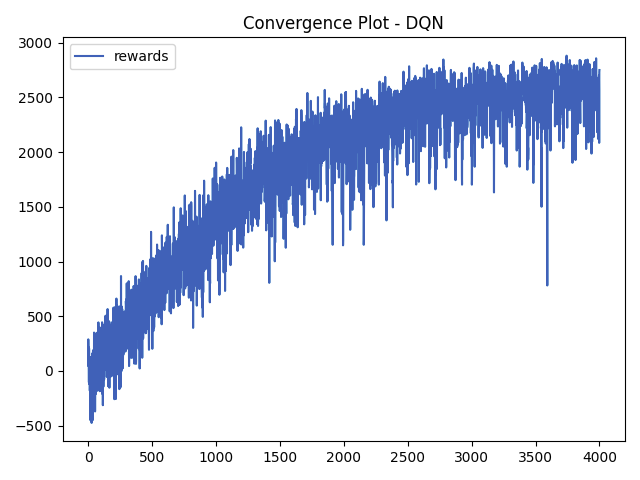

In [ ]:
def convergence_graph_q_val(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()


In [ ]:
print('\n\033[1m'+"Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)\n")
convergence_graph_q_val(fig_num=1, state=(2,4,6), action=(2,3), states_tracked= states_tracked_1)


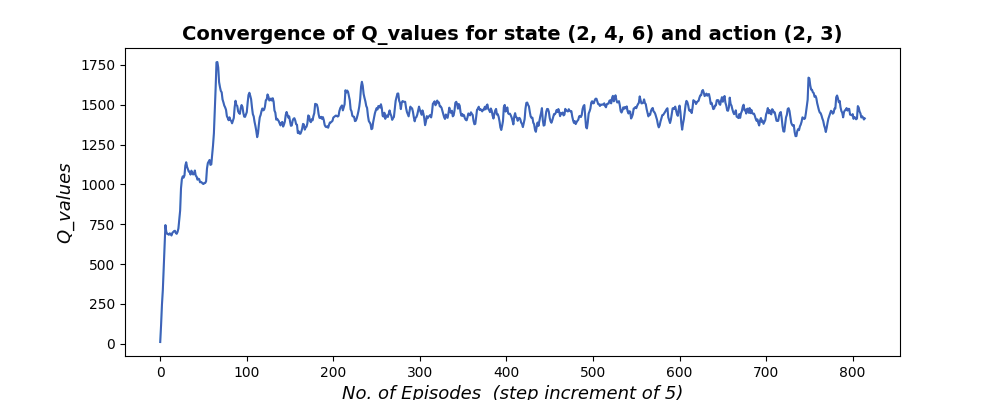

In [ ]:
print('\n\n\n\033[1m'+"Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)\n")
convergence_graph_q_val(fig_num=3, state=(1,2,3), action=(1,2), states_tracked= states_tracked_2)


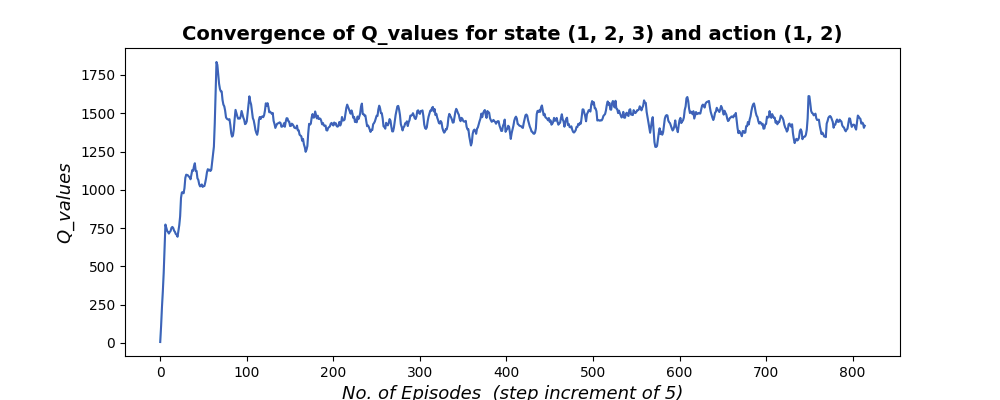

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

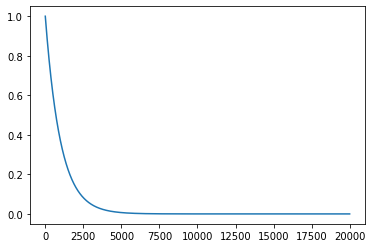

In [7]:
time = np.arange(0,Episodes)
epsilon = []
for i in range(0,Episodes):
    epsilon.append(0 + (1 - 0) * np.exp(-agent.decay_rate*i))
  
plt.plot(time, epsilon)
plt.show()